# MPG Cars Prediction 

In the following, I use ***Auto-Mpg*** dataset (Mileage per gallon performances of various cars) to build moldes to predict MPG:
- two **Linear Regression** model ( with original data and normalized data)
- one **ElasticNet** model 

Dataset reference: https://www.kaggle.com/uciml/autompg-dataset

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

In [2]:
pd.__version__, sns.__version__

('1.3.4', '0.11.1')

## Uploading Dataset

In [3]:
df = pd.read_csv('data/auto-mpg-kaggle.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
# horsepower is expected to be integer
df[~(df['horsepower'].str.isdigit())]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


In [6]:
df['horsepower'].replace({'?': np.nan}, inplace=True)

In [7]:
# converting string to float instead of int (because np.nan cannot be converted to int in current pandas version)
df['horsepower'] = df['horsepower'].astype(np.float64)
df['horsepower'].dtype

dtype('float64')

## Exploring Data

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


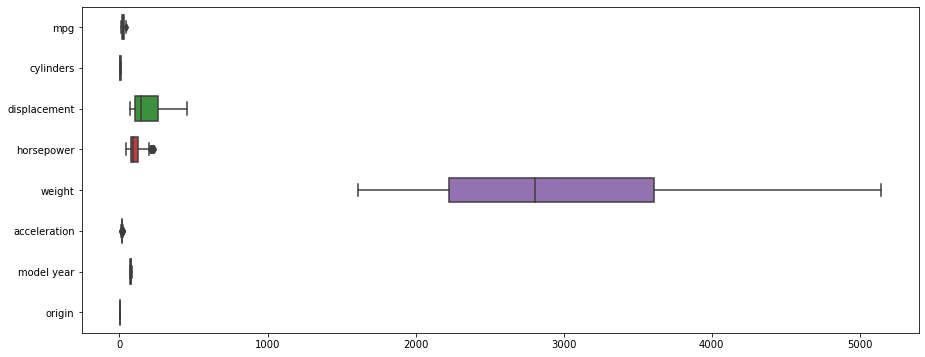

In [9]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df, orient='h', width=.6);

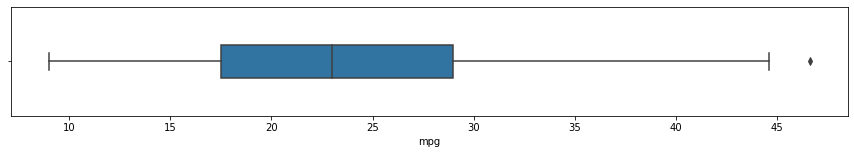

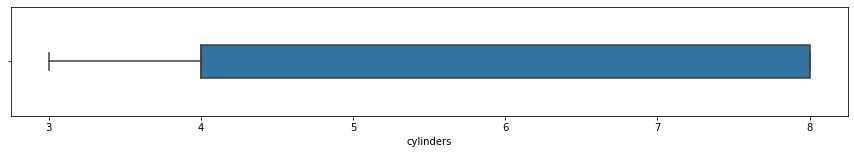

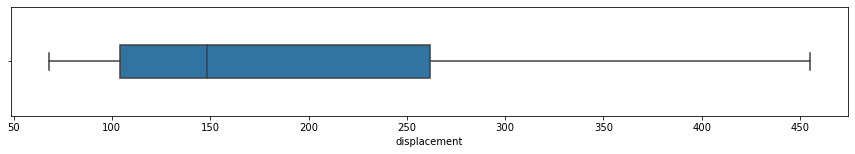

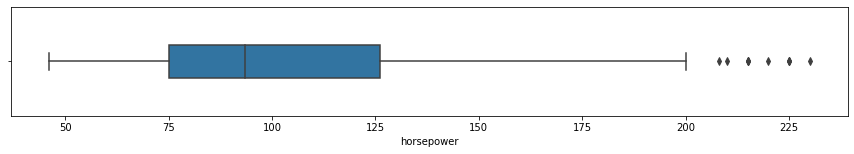

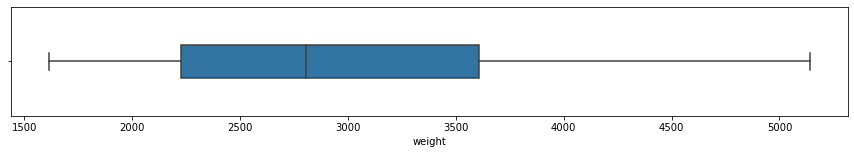

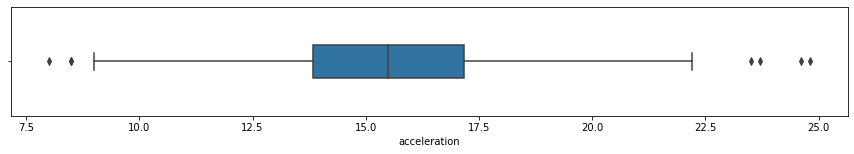

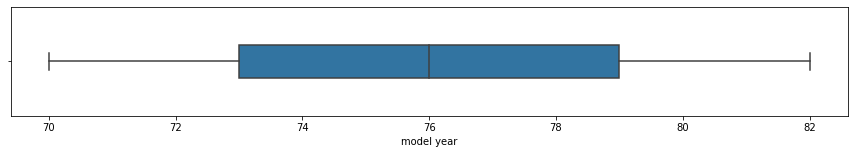

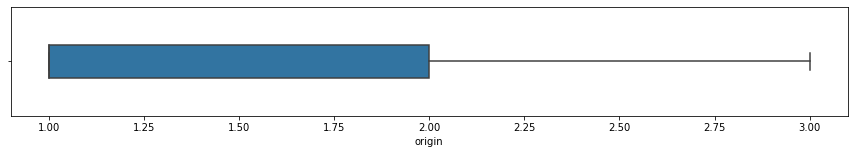

In [10]:
num_features = df.select_dtypes(exclude='object').columns

for f in num_features:
    plt.figure(figsize=(15,2))
    sns.boxplot(x=f, data=df, width=.3)

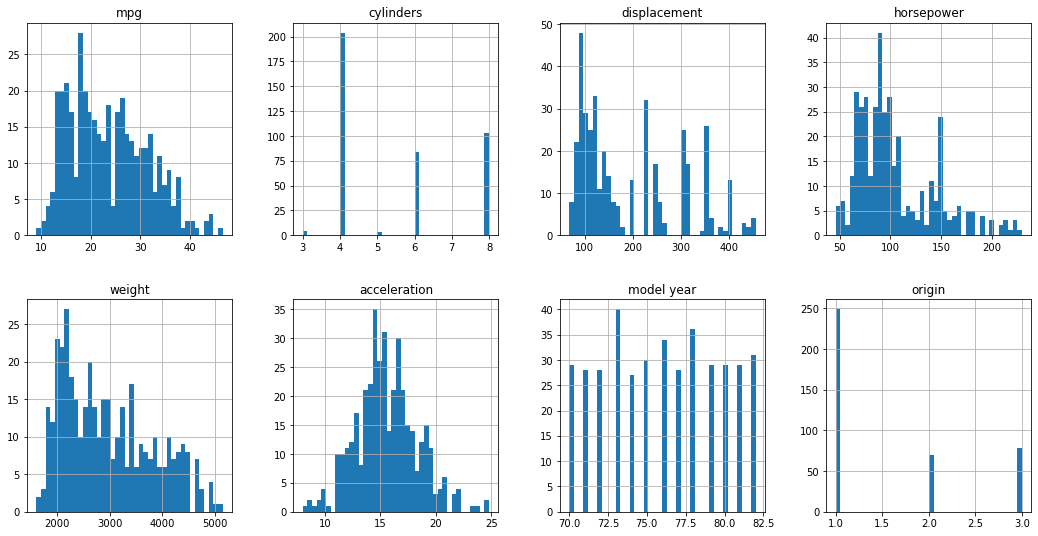

In [11]:
df.hist(figsize=(18,9), layout=(2,4), bins=40);

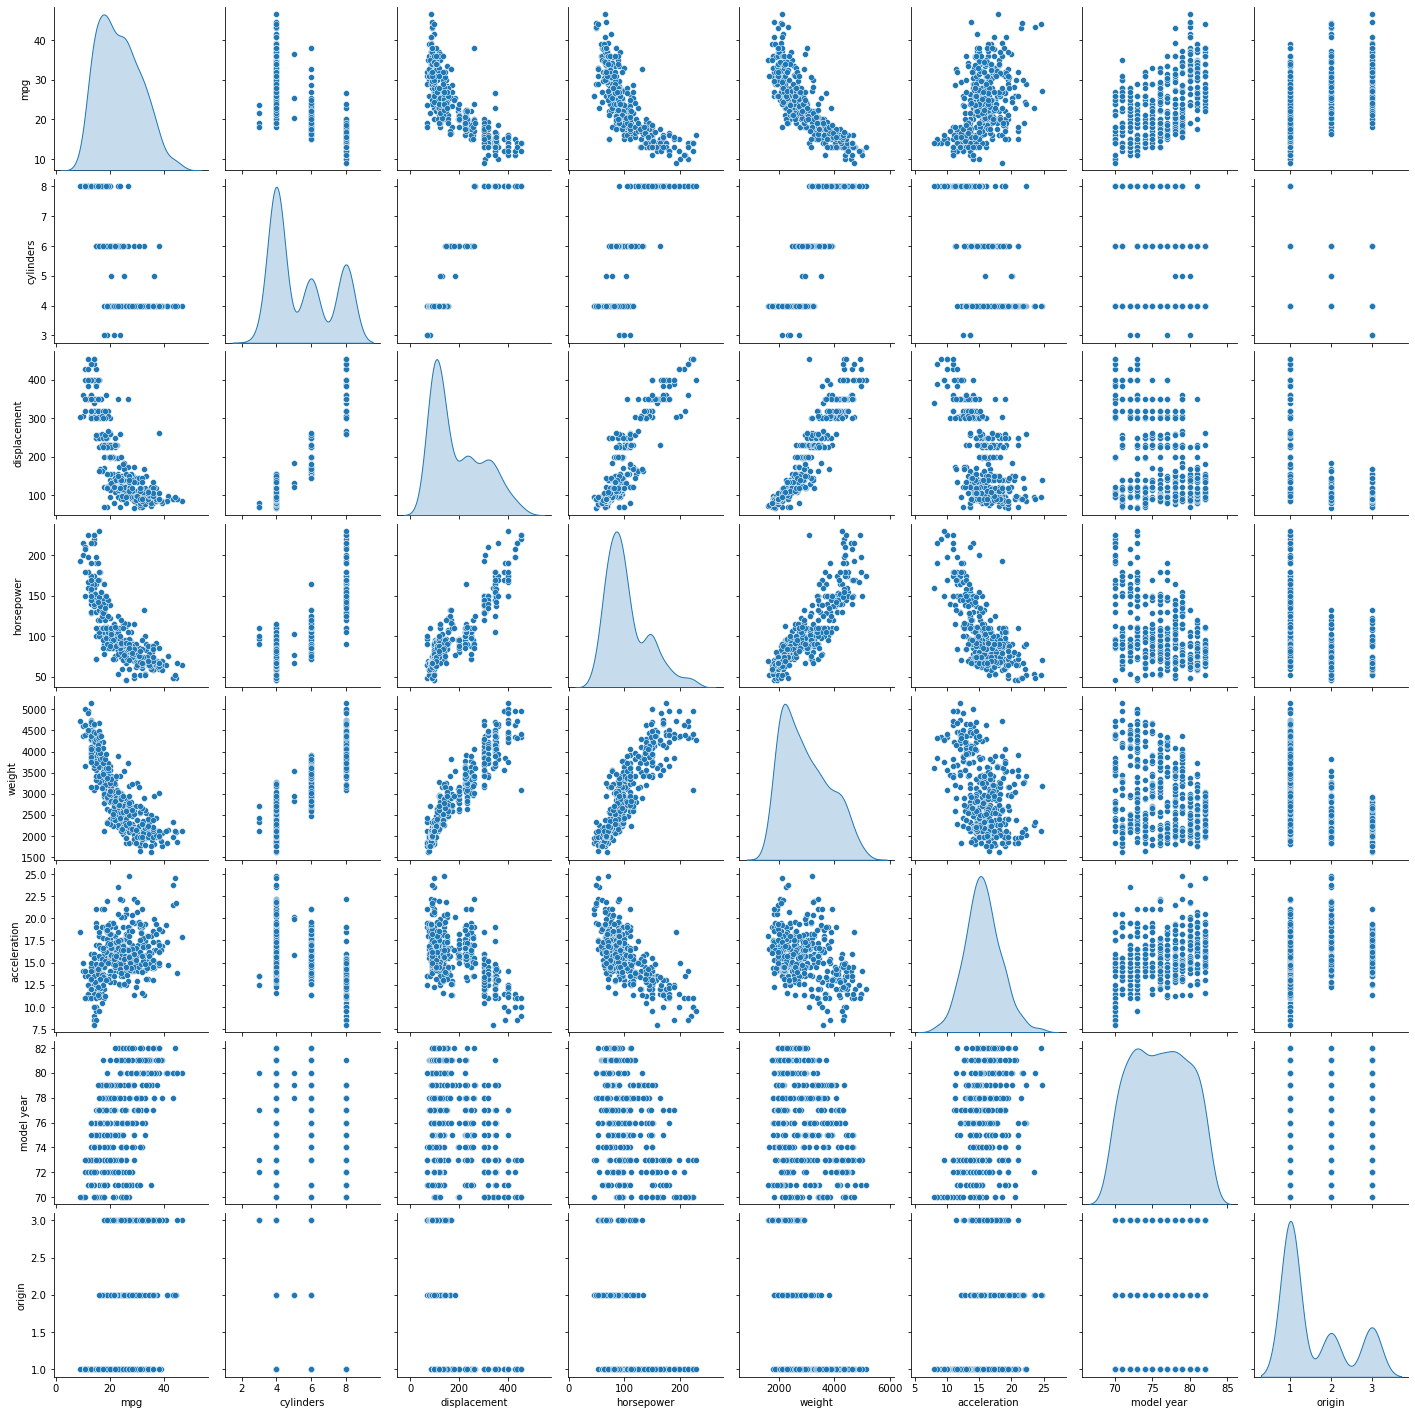

In [12]:
sns.pairplot(df, kind='scatter', diag_kind='kde');

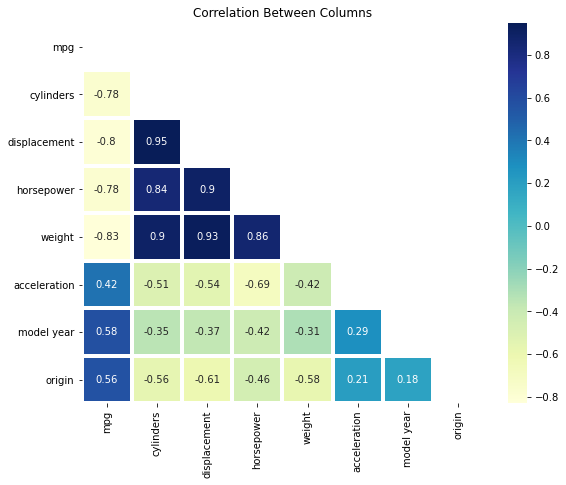

In [13]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

plt.figure(figsize=(9,7))
sns.heatmap(df.corr(), annot=True, mask=mask, lw=3, cmap='YlGnBu')
plt.title('Correlation Between Columns');

In [14]:
df.corr()['mpg'].sort_values()

weight         -0.831741
displacement   -0.804203
horsepower     -0.778427
cylinders      -0.775396
acceleration    0.420289
origin          0.563450
model year      0.579267
mpg             1.000000
Name: mpg, dtype: float64

## Data Preparation

### Removing columns:

In [15]:
df['car name'].nunique()

305

In [16]:
df.drop(['car name'], axis=1, inplace=True)

### Converting categorical data:

In [17]:
df['origin'].value_counts()

1    249
3     79
2     70
Name: origin, dtype: int64

In [18]:
# encoding categorical data for 'origin' column
df = pd.get_dummies(df, columns=['origin'], drop_first=False)
df.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0


### Spliting data:

In [19]:
# spliting data into testing and training sets
X = df.drop('mpg', axis=1)
y = df['mpg']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=2)

### Filing missing values:

In [20]:
X.isna().sum()

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin_1        0
origin_2        0
origin_3        0
dtype: int64

In [21]:
x_test.isna().sum().sum(), x_test.isna().sum().sum()

(3, 3)

In [22]:
# to prevent data leak the median of x_train['horsepower'] is replaced for null values
hr_med = x_train['horsepower'].median()
x_train = x_train.fillna(hr_med)
x_test = x_test.fillna(hr_med)

### Feature normalization:

In [23]:
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)
scaled_x_test = scaler.transform(x_test)

In [24]:
pd.DataFrame(scaled_x_train, columns=X.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
cylinders,298.0,-1.479056e-16,1.001682,-1.449648,-0.852970,-0.852970,0.340387,1.533743
displacement,298.0,4.507953e-17,1.001682,-1.223281,-0.856302,-0.411033,0.636081,2.563947
horsepower,298.0,8.978649e-17,1.001682,-1.553296,-0.737326,-0.242394,0.466563,3.369275
weight,298.0,7.413905e-17,1.001682,-1.641864,-0.875378,-0.169255,0.742758,2.573957
acceleration,298.0,-8.583738e-16,1.001682,-2.727416,-0.572671,-0.033984,0.567549,3.305871
model year,298.0,6.780557e-17,1.001682,-1.620388,-0.814700,-0.009012,0.796676,1.602364
origin_1,298.0,5.737394e-17,1.001682,-1.355764,-1.355764,0.737592,0.737592,0.737592
origin_2,298.0,2.242800e-16,1.001682,-0.438178,-0.438178,-0.438178,-0.438178,2.282177
origin_3,298.0,-3.964018e-16,1.001682,-0.486328,-0.486328,-0.486328,-0.486328,2.056227


## Building & Evaluating Linear Regression Model

In [25]:
def plot_coefs(array, index=X.columns):
    coef_df = pd.DataFrame(array.reshape(-1,1), index=index, columns=['coef'])
    plt.figure(dpi=100)
    coef_df['coef'].sort_values().plot.bar();

### Building models with un-scaled features

In [26]:
linear_m = LinearRegression()
linear_m.fit(x_train, y_train)

LinearRegression()

In [27]:
linear_m.coef_

array([-0.66134805,  0.03186452, -0.02594493, -0.00701881,  0.0499412 ,
        0.77064845, -1.97064305,  1.31838123,  0.65226182])

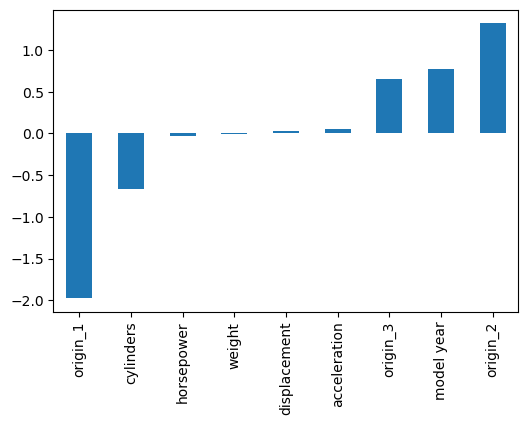

In [28]:
plot_coefs(linear_m.coef_)

In [29]:
# intercept of the linear regression
linear_m.intercept_

-14.10247633799445

In [30]:
# R-Squared score on training set
linear_m.score(x_train, y_train)

0.8099048338795962

In [31]:
# R-Squared score on testing set
linear_m.score(x_test, y_test)

0.8563204692483772

In [32]:
y_pred1 = linear_m.predict(x_test)
MAE1 = mean_absolute_error(y_test, y_pred1)
RMSE1 = np.sqrt(mean_squared_error(y_test, y_pred1))

In [33]:
MAE1, RMSE1

(2.3144901576321204, 3.0022949344749605)

### Building models with scaled features

In [34]:
linear_model = LinearRegression()
linear_model.fit(scaled_x_train, y_train)

LinearRegression()

In [35]:
# co-efficient of each feature 
linear_model.coef_

array([-1.10838311,  3.2560932 , -0.96979119, -5.87200705,  0.13906387,
        2.86952953, -0.78401127,  0.60573339,  0.38610404])

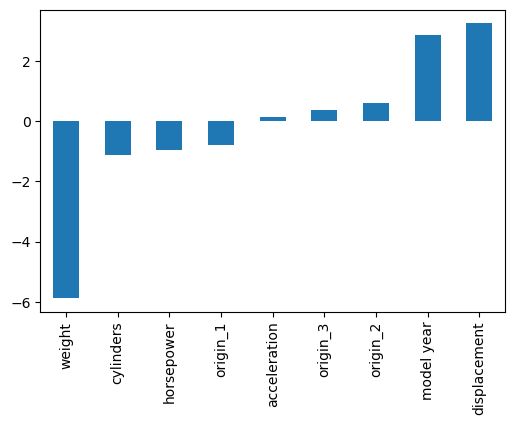

In [36]:
plot_coefs(linear_model.coef_)

In [37]:
# intercept of the linear regression
linear_model.intercept_

23.22919463087248

In [38]:
# R-Squared score on training set
linear_model.score(scaled_x_train, y_train)

0.8099048338795962

In [39]:
# R-Squared score on testing set
linear_model.score(scaled_x_test, y_test)

0.8563204692483772

In [40]:
y_pred = linear_model.predict(scaled_x_test)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

In [41]:
MAE, RMSE

(2.3144901576321213, 3.0022949344749614)

## Regularization

In [45]:
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95, .99, 1], eps=0.001, n_alphas=100, tol=0.01)

In [46]:
elastic_model.fit(scaled_x_train, y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], tol=0.01)

In [47]:
elastic_model.get_params()

{'alphas': None,
 'copy_X': True,
 'cv': None,
 'eps': 0.001,
 'fit_intercept': True,
 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': None,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.01,
 'verbose': 0}

In [48]:
elastic_model.l1_ratio_

0.99

In [49]:
elastic_model.coef_

array([-0.95276043,  2.92400897, -0.9221428 , -5.76786459,  0.12435205,
        2.853775  , -1.21829826,  0.23609899,  0.        ])

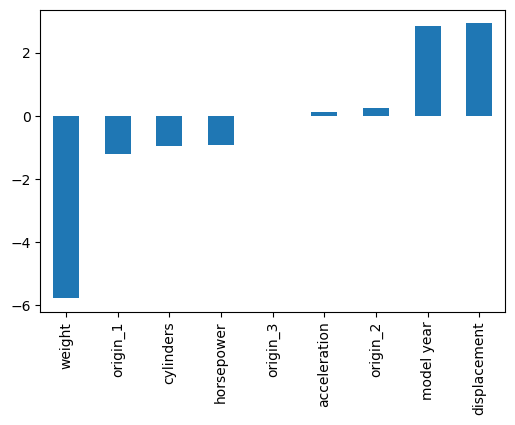

In [51]:
plot_coefs(elastic_model.coef_)

In [52]:
y_pred3 = elastic_model.predict(scaled_x_test)
MAE3 = mean_absolute_error(y_test, y_pred3)
RMSE3 = np.sqrt(mean_squared_error(y_test, y_pred3))

MAE3, RMSE3

(2.30325646540299, 2.9875008739888367)

In [53]:
y_test.describe()

count    100.000000
mean      24.365000
std        7.960463
min        9.000000
25%       17.900000
50%       24.500000
75%       30.125000
max       44.600000
Name: mpg, dtype: float64

In [55]:
print('comparing:\n   STD = %.3f with\n   RMSE = %.3f , \nit is concluded that the model performance is good.' % (y_test.std(), RMSE3))

comparing:
   STD = 7.960 with
   RMSE = 2.988 , 
it is concluded that the model performance is good.


In [57]:
# RMSE for training set
train_preds = elastic_model.predict(scaled_x_train)
np.sqrt(mean_squared_error(y_train, train_preds))

3.3781670764822427

**Question:** is the model overfiting? 

 - No, because RMSE of the testing set is lower than RMSE of the training set.